In [1]:
# default_exp analyses

# Probability of First Recall
> The first recall a participant makes in a free recall experiment 

## Data Preparation
For our demonstrations, we'll lean on the MurdockOkada1970 dataset. 
As a reminder, in this dataset each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min.

In [2]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data("../../data/mo1970.txt")
events.head()


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,0,1,NaN,True,False,0,False
1,1,1,1,2,NaN,True,False,0,False
2,1,1,2,3,NaN,True,False,0,False
3,1,1,3,4,NaN,True,False,0,False
4,1,1,4,5,NaN,True,False,0,False


## Analysis

### DataFrame
We can usually rely on the `psifr` library to generate `pandas` DataFrames containing PFR information. 

In [3]:
from psifr import fr

pfr = fr.pnr(events).query("output <= 1")
pfr


prob  actual  possible
subject output input                        
1       1      1      0.00       0        20
               2      0.00       0        20
               3      0.00       0        20
               4      0.00       0        20
               5      0.00       0        20
...                    ...     ...       ...
72      1      16     0.05       1        20
               17     0.50      10        20
               18     0.15       3        20
               19     0.10       2        20
               20     0.05       1        20

[1440 rows x 3 columns]

### Fast Array Generation
`DataFrame`s contain granular subject-by-subject information and are easier to plot using the `seaborn` library. 
But sometimes we don't need this granular information and mainly want to perform our analysis as quickly as possible -- perhaps to help with model fitting or analysis. 
In that case, representing results with `numpy` arrays and performing just-in-time compilation of our function using `numba` might be preferred. 
We include `analyses.fast_crp` in our library for that purpose here.

In [4]:
# export

from numba import njit
import numpy as np


@njit(fastmath=True, nogil=True)
def fast_pfr(trials, item_count):
    return np.bincount(trials[:, 0], minlength=item_count + 1)[1:] / len(trials)


In [5]:
fast_pfr(trials, list_length)

array([0.06666667, 0.00347222, 0.00208333, 0.00208333, 0.00416667,
       0.00138889, 0.00694444, 0.00416667, 0.00763889, 0.01458333,
       0.00902778, 0.01597222, 0.03055556, 0.03472222, 0.05694444,
       0.09027778, 0.13402778, 0.18611111, 0.15347222, 0.17569444])

We can compare the runtimes of `compmemlearn`'s and `psifr`'s functions using the `%%timeit` Jupyter magic:

In [6]:
%%timeit
fast_pfr(trials, list_length)

3.75 µs ± 78.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
%%timeit
fr.pnr(events)

560 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our fast implementation is more than 100,000 times faster!

## Plotting
`psifr`'s plotting library creates a separate figure for each plot, when sometimes we want to to include multiple plots in one figure, so we define our own.

In [8]:
# # export

# import seaborn as sns
# import matplotlib.pyplot as plt
# from psifr import fr
# from compmemlearn.fitting import apply_and_concatenate

# def plot_pfr(data, list_length, axis=None, contrast_name=None, labels=None):

#     if axis is None:
#         plt.figure()
#         axis = plt.gca()

#     if isinstance(data, list):
#         assert(len(labels) == len(data))
#         assert(contrast_name is not None)
#         data = apply_and_concatenate(fr.pnr, data, contrast_name, labels)
#         data = data.query("output <= 1")
#     else:
#         data = fr.pnr(data)
#         data = data.query("output <= 1")

#     sns.lineplot(ax=axis, data=data, x='input', y='prob', err_style='bars', hue=contrast_name)
#     axis.set(xlabel='Study Position', ylabel='Probability of Recalling First')
#     axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
#     axis.set_ylim((0, 1))

#     if labels is not None:
#         axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     return axis

In [9]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_pfr(data, trial_query, contrast_name='', labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths = events_metadata(events)[:2]
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, list_length + 1),
                    "recall": fast_pfr(trials[subject_specific_trial_mask], list_length),
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result).reset_index()

    sns.lineplot(ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')
    axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

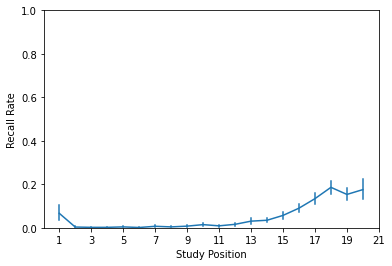

In [10]:
import matplotlib.pyplot as plt

plt.figure()
axis = plt.gca()
plot_pfr([events], 'subject > -1', axis=axis);